# Copyright
<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült,
a https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/word2vec oldalon található kód felhasználásával.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük az alábbi szerzőt értesíteni.

2016 (c) Szaszák György (szaszak kukac tmit pont bme pont hu)
</PRE>

## Szövegkorpusz és tokenizálása
A wikipédia mentését tartalmazó nagy szövegkorpuszt használunk. Tömrítve tárolt, kicsomagolás után tokenizáljuk: azaz szavakra bontjuk, az írásjeleket kidobáljuk belőle.

In [1]:
# -*- coding: utf-8 -*-

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import xrange
import tensorflow as tf

# Angol wikipédiáról származó adatok
filename="text8.zip"

# Kicsomagoljuk és beolvassuk a fájlt, listába kerülnek belőle a szavak egymás után, ahogy jönnek (.split())
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Szavak száma: ', len(words))


Szavak száma:  17005207


## Összerakjuk a szótárat és a tanítómintákat listába tesszük
Mivel nagyon sok különböző szó van, húzunk egy plafont, mennyi különböző szót modellezünk. A többit kihagyjuk és egy közös "ismeretlen" szimbólumra változtatjuk. Természetesen az a célszerű, ha gyakoriság szerint rendezzük a szótárat és a leggyakoribbakat megtartjuk, és a ritkákból hagyunk veszni. A ritkaság miatt úgyis nehéz lenne a modellezés.
Ha ezzel megvagyunk, egész azonosíót rendelünk sorban a szavakhoz. Ezt egy szótárba tesszük, és az inverz átalakítást is elkészítjük hozzá, hogy számokat vissza tudjunk alakítani szavakra.

In [2]:
vocabulary_size = 50000 # Maximum szavak száma (ami nem fér bele, egy közös "szemeteskosárra" képezzük: UNK

def build_dataset(words):
  count = [['UNK', -1]] # Countban a szavak és hogy hány van belőlük. Az UNK is egy szó, amelyre az összes ismeretlent képezzük le, értékét később állítjuk be.
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # Gyakorisági sorrendbe rendezzük, mert csak a leggyakoribb szavakat tartjuk meg
  dictionary = dict() # Ez lesz a szó -> egész azonosító leképezés tábla
  for word, _ in count: # Végigmegyünk az összes szón...
    dictionary[word] = len(dictionary) # Bekerül a szótárba
  data = list() # data fogja tartalmazni a szavak számokra leképzett alakját listaként
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK'] a 0. elem
      unk_count += 1 # Számoljuk, hány olyan szó van, amelyet UNK-ra képztünk le (mert ritka)
    data.append(index)
  count[0][1] = unk_count # UNK 0. elem a countban, annak második tagja az előfordulások száma
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  # Visszaadjuk az adatokat (lista, szavak egész azonsítóval benne); a szavak és előfordulásaik számának tömbjét (count),
  # a szótárat (szavak -> szám) és a fordítottját (szám -> szó)
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Memóriatakarékosság végett
print('Az 5 leggyakoribb szó (+UNK)', count[:5])
print('Az adatokból az első 16 minta', data[:16], [reverse_dictionary[i] for i in data[:16]])

data_index = 0

Az 5 leggyakoribb szó (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Az adatokból az első 16 minta [5235, 3084, 12, 6, 195, 2, 3136, 46, 59, 156, 128, 742, 477, 10607, 134, 1] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']


## Minibatch genenerátort csinálunk skip gram tanításához
A skip gram egy adott szóra (target) ad  kontextusbecslést. Tanításakor a skip_window által megadott intervallumban egy adott target szó körül vizsgálódunk. Innen num_skips mintát veszünk véletlenszerűen a kontextusból. 

In [4]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index # A globális változó azért kell, hogy ismételt híváskor ne induljunk megint elölről
  assert batch_size % num_skips == 0 # egész számnak kell lennie, ennyi szó megy a bemenetre majd
  assert num_skips <= 2 * skip_window # nem lóghatunk ki az ablakból akkor sem, ha a teljes kontextust használjuk
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # A minta két oldalára tesszük rá a skip_window-t: [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span) # deque: kétoldalt bővíthető lista
  for _ in range(span):
    buffer.append(data[data_index]) # buffer-be betesszük az érintett szavakat; közepén a bemenet, tőle balra-jobbra kimenetek
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips): # ennyi szóra tudunk most mintát generálni
    target = skip_window  # bemenet (target, mert a skip gramban az input és target helyet cserélnek) a buffer középső eleme tehát
    targets_to_avoid = [ skip_window ] # aki már volt, többet ne legyen
    for j in range(num_skips): # ennyi mintát veszünk a kimenetre adott bemenethez
      while target in targets_to_avoid:
        target = random.randint(0, span - 1) # Véletlenszerű mintavételezés a szó előtt és után skip_windowon belüli elemekből
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window] # Bemenet, num_skip-szer ismétlődik
      labels[i * num_skips + j, 0] = buffer[target] # az egyes kiemenetek (num_skip darab egy bemenetre)
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

## Példaként generálunk egy rövid batch-et
Meg lehet figyelni, hogy data_indexhez képesti skip_window-adik szótól indul, kimenetre ad mellé num_skip elemet.

In [5]:
print('Az adatokból az első 16 minta', data[:16], [reverse_dictionary[i] for i in data[:16]])
data_index=0
print ("Data index: ", data_index)
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

print ("="*50)
print ("Data index: ", data_index)
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)


for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
      '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

print ("Data index: ", data_index)

Az adatokból az első 16 minta [5235, 3084, 12, 6, 195, 2, 3136, 46, 59, 156, 128, 742, 477, 10607, 134, 1] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
Data index:  0
3084 originated -> 12 as
3084 originated -> 5235 anarchism
12 as -> 6 a
12 as -> 3084 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of
Data index:  7
156 against -> 128 early
156 against -> 742 working
128 early -> 477 class
128 early -> 59 used
742 working -> 477 class
742 working -> 128 early
477 class -> 742 working
477 class -> 128 early
Data index:  16


## Modell összeállítása
Most már rendes batch-eket csinálunk, végig a korpuszon. Közben készül egy pici validációs halmaz is, hogy tanulás közben tudjunk logolni.

In [6]:
batch_size = 128
embedding_size = 128  # embedding dimenziós (órán N volt)
skip_window = 1       # Balról is és jobbról is ennyi mintát veszünk a szó környezetéből
num_skips = 2         # Hányszor használjunk egy bemenetet (pl. skip_window * 2, de ha kevesebb, akkor mintavételezünk egy tágabb szókontextust

# Csinálunk egy random validációs halmazt
valid_size = 16	    # Minták száma validációhoz
valid_window = 100  # Csak a 100 leggyakoribb szóból
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # A negatív minták száma lesz majd ennyi

graph = tf.Graph()

with graph.as_default():

  # Input adatok
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # CPU / GPU
  with tf.device('/cpu:0'):  # with tf.device('/gpu:0'):
    # Embeddingek, V x N, random init, bemenetre kötve
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # NCE (Noise Contrastive Estimation) loss-t fogunk számolni, ehhez segédváltozók
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # A tf.nce_loss minden kiértékelésre új negatív mintákat (szavakat) generál
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

  # SGD, tanulási ráta: 1.0 (nagy!).
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Koszinusz hasonlóság a minibatchban kapott és a meglévő embeddingek között
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Inicializáljuk a változókat
  init = tf.initialize_all_variables()



## Tanítjuk a modellt
Közben logoljuk a választott validációs halmazra a 8, a target kontextusaként leggyakrabban előforduló szót.

In [7]:
# Tanítás
num_steps = 100001

with tf.Session(graph=graph) as session:
    
  init.run() # Inicializálás

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # Update és loss számítása a validációs halmazon (random minták a 100 leggyakoribb szóból)
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # 2000 batchenként átlagos hibát számolunk
      print("Átlagos hiba a ", step, ". lépésben : ", average_loss)
      average_loss = 0

    # Hasonlóság logolása 10000 batchenként (nem gyakrabban, mert számításigényes nagyon)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # k legközelebbi szomszéd
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = " %s -> " % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Átlagos hiba a  0 . lépésben :  274.866577148
 have ->  hunchback, extremism, rigged, kvac, undecidability, jumpers, nubcake, incendiary,
 system ->  scaled, equivalents, probation, carbohydrates, hogg, clemency, drab, animalium,
 when ->  aka, mumonkan, explored, monterrey, astrakhan, nuova, juden, warrant,
 has ->  mergers, goin, horrendous, canterbury, mauro, networked, swapped, hospitality,
 see ->  connotes, duma, adulterated, straczynski, ashford, installer, deemed, hearts,
 more ->  bronfman, varela, trousers, tnf, sybil, oxford, unam, particular,
 it ->  deceiving, erne, sikh, studied, embellishment, spectrometry, batman, mo,
 three ->  antidepressant, hanjour, glengarry, rcr, vig, acquaintance, nol, gentry,
 after ->  montag, america, campaigned, vented, birkenau, karts, polymorphic, samara,
 called ->  poset, lvaro, legionaries, los, increases, commonality, somalia, emigrant,
 for ->  desirable, baker, ppp, shikoku, ttingen, est, warrington, galvani,
 UNK ->  gateways, palsy,

## Embeddingek megjelenítése 2D ábrán

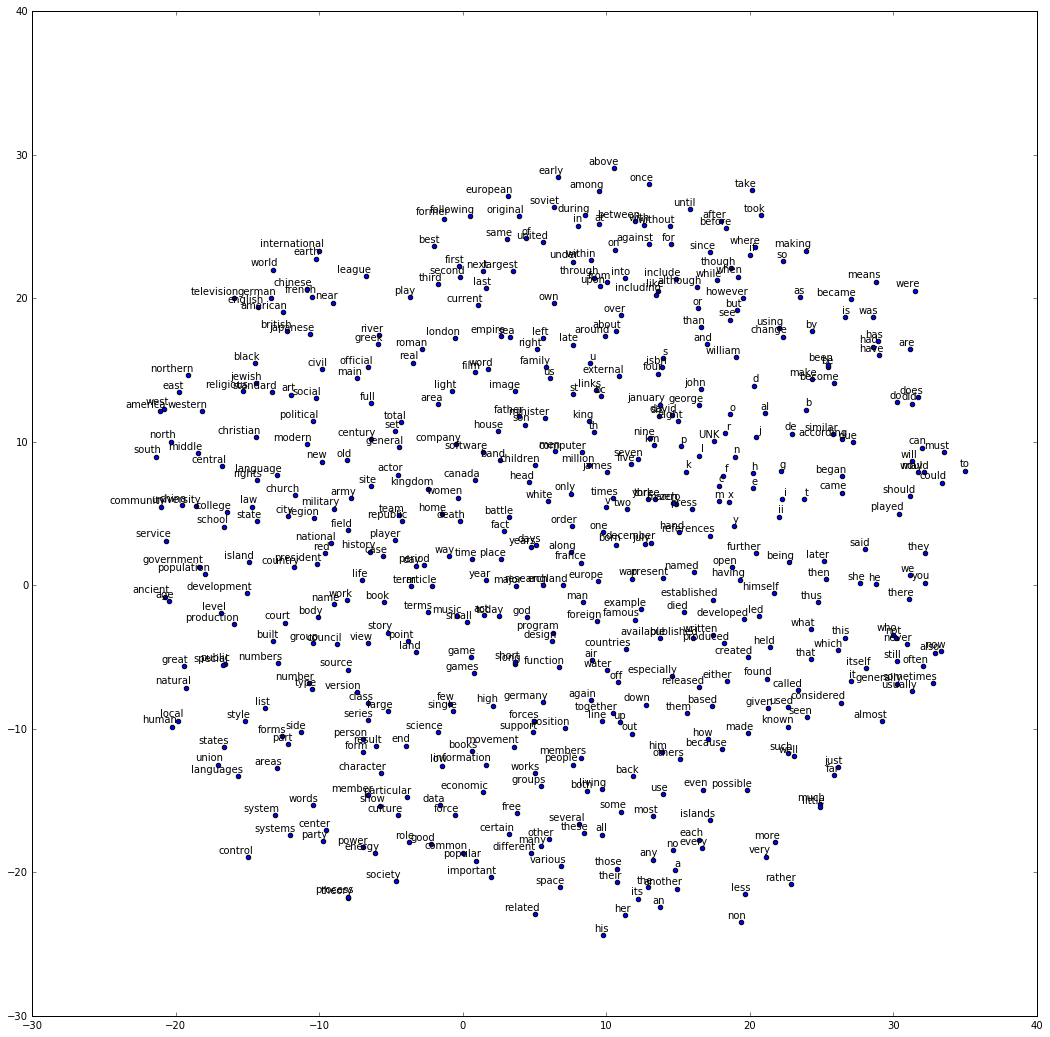

In [9]:
def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.show()

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")